In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
def analyze(forward_work, reverse_work, forward_accumulated, reverse_accumulated, dir_num, phase, output_dir, title): 
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    # Compute dg, ddg
    print("computing dg, ddg")
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    
    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    
    # Compute free energy 
    return dg, ddg
    

In [19]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
titles = ["T42A", "A42T"]
d_results = {}
d_phases = {}
first = 11
for i in tqdm_notebook([11, 12]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/8/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
#                 if j < 63 or j > 69:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
#                 if j < 63 or j > 69:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)
    if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
#     if forward_complex_arrays and reverse_complex_arrays:
#     if forward_apo_arrays and reverse_apo_arrays:
        
        forward_complex_combined = np.concatenate(forward_complex_arrays)
        forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
        forward_complex_combined = np.array([cycle[0::100] for cycle in forward_complex_combined])
        print(forward_complex_combined.shape)
        
        reverse_complex_combined = np.concatenate(reverse_complex_arrays)
        reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        reverse_complex_combined = np.array([cycle[0::100] for cycle in reverse_complex_combined])
        
        forward_apo_combined = np.concatenate(forward_apo_arrays)
        forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
        forward_apo_combined = np.array([cycle[0::100] for cycle in forward_apo_combined])
        print(forward_apo_combined.shape)
        
        reverse_apo_combined = np.concatenate(reverse_apo_arrays)
        reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
        reverse_apo_combined = np.array([cycle[0::100] for cycle in reverse_apo_combined])
        
        # Analyze
        complex_dg, complex_ddg = analyze(forward_complex_combined, reverse_complex_combined, forward_complex_accumulated, reverse_complex_accumulated, i, 'complex', os.path.dirname(forward_complex_path), titles[i-first])
        apo_dg, apo_ddg = analyze(forward_apo_combined, reverse_apo_combined, forward_apo_accumulated, reverse_apo_accumulated, i, 'apo', os.path.dirname(forward_apo_path), titles[i-first])
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        d_results[titles[i-first]] = [binding_dg, binding_ddg]
#         print(f"complex_dg: {complex_dg}")
#         print(f"apo dg: {apo_dg}, ddg: {apo_ddg}")
        print(f"apo dg: {apo_dg}, complex_dg: {complex_dg}")
        d_phases[titles[i-first]] = [apo_dg, apo_ddg, complex_dg, complex_ddg]
#         d_phases[titles[i-first]] = [apo_dg, apo_ddg]
    else:
        print(f"dir {i} has at least one phase without data" )

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


dir: 11
job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
job: 12
job: 13
job: 14
job: 15
job: 16
job: 17
job: 18
job: 19
job: 20
job: 21
job: 22
job: 23
job: 24
job: 25
job: 26
job: 27
job: 28
job: 29
job: 30
job: 31
job: 32
job: 33
job: 34
job: 35
job: 36
job: 37
job: 38
job: 39
job: 40
job: 41
job: 42
job: 43
job: 44
job: 45
job: 46
job: 47
job: 48
job: 49
job: 50
job: 51
job: 52
job: 53
job: 54
job: 55
job: 56
job: 57
job: 58
job: 59
job: 60
job: 61
job: 62
job: 63
job: 64
job: 65
job: 66
job: 67
job: 68
job: 69
job: 70
job: 71
job: 72
job: 73
job: 74
job: 75
job: 76
job: 77
job: 78
job: 79
job: 80
job: 81
job: 82
job: 83
job: 84
job: 85
job: 86
job: 87
job: 88
job: 89
job: 90
job: 91
job: 92
job: 93
job: 94
job: 95
job: 96
job: 97
job: 98
job: 99
dir 11 has at least one phase without data
dir: 12
job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
job: 12
job: 13
job: 14
job: 15
job: 16
job: 17
job: 18
job: 19
j

In [5]:
d_results

{'T42A': [2.4518428895870272, 0.19580446266908086],
 'A42T': [-1.1032913214696904, 0.1640769272454853]}

In [6]:
d_phases

{'T42A': [47.663253316044894,
  0.06246702338685891,
  50.11509620563192,
  0.18557278515534845],
 'A42T': [-47.395605856624584,
  0.07902953482614831,
  -48.498897178094275,
  0.14379002287878978]}

In [11]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/d_results.pickle", "wb") as f:
    pickle.dump(d_results, f)

import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/d_phases.pickle", "wb") as f:
    pickle.dump(d_phases, f)


In [4]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/d_results.pickle", "rb") as f:
    d_results = pickle.load(f)

import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/d_phases.pickle", "rb") as f:
    d_phases = pickle.load(f)

In [ ]:
# # Format to match Dominic's table
# d_combined = {}
# rows = [('ALA', 'SER'), ('ALA', 'CYS'), ('ALA', 'THR'), ('SER', 'CYS'), ('SER', 'THR'), ('CYS', 'THR')]
# for pair, (dg, ddg) in sorted(d_results.items()):
#     if pair in rows:
#         d_combined[pair] = [dg, ddg]

# for pair, (dg, ddg) in sorted(d_results.items()):
#     if pair not in d_combined:
#         reversed_pair = pair[::-1]
#         forward_solvation_dg = d_combined[reversed_pair][0]
#         forward_solvation_ddg = d_combined[reversed_pair][1]
#         d_combined[reversed_pair] += [dg, ddg, abs(forward_solvation_dg) - abs(dg), abs(forward_solvation_ddg) - abs(ddg)]



In [ ]:
# # Create dataframe
# df = pd.DataFrame.from_dict(d_combined, orient='index', columns=['forward solvation dG', 
#                                                             'forward solvation ddG', 
#                                                             'reverse solvation dG',
#                                                             'reverse solvation ddG',
#                                                             'discrepancy dG',
#                                                             'discrepancy ddG'
#                                                            ]
                      
#                       )

In [ ]:
# df.reindex(index=rows)

# Make traj for movie

Complex neq

In [25]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex.pickle", "rb") as f:
    htf = pickle.load(f)

ModuleNotFoundError: No module named 'oechem'

In [8]:
import numpy as np
with open("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_99_forward_neq_old.npy", "rb") as f:
    fwd_pos = np.load(f)

In [9]:
import numpy as np
with open("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_99_reverse_neq_old.npy", "rb") as f:
    rev_pos = np.load(f)

In [14]:
import mdtraj as md
md.Trajectory(fwd_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_99_forward_neq_old.dcd")



In [15]:
import mdtraj as md
md.Trajectory(rev_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_99_reverse_neq_old.dcd")



In [16]:
md.Trajectory(fwd_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))[0].save("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_99_forward_neq_old.pdb")



In [17]:
md.Trajectory(rev_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))[0].save("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_complex_99_reverse_neq_old.pdb")


Apo neq

In [1]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo.pickle", "rb") as f:
    htf = pickle.load(f)

In [2]:
import numpy as np
with open("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo_99_forward_neq_old.npy", "rb") as f:
    fwd_pos = np.load(f)

In [3]:
import numpy as np
with open("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo_99_reverse_neq_old.npy", "rb") as f:
    rev_pos = np.load(f)

In [39]:
solute_indices = md.Topology.from_openmm(htf._topology_proposal.old_topology).select("not water")
solute_top = md.Topology.from_openmm(htf._topology_proposal.old_topology).subset(solute_indices)
# for atom in top.atoms:
# #     if atom.residue.name in ['NA', 'CL', 'HOH']:
#     if int(atom.index) > 1440:
#         print(atom.residue.name, atom.index)
# #         top.delete_atom_by_index(atom.index)

In [41]:
for atom in solute_top.atoms:
    print(atom.residue.name, type(atom.index))

ACE <class 'int'>
ACE <class 'int'>
ACE <class 'int'>
ACE <class 'int'>
ACE <class 'int'>
ACE <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
LYS <class 'int'>
ALA <class 'int'>
ALA <class 'int'>
ALA <class 'int'>
ALA <class 'int'>
ALA <class 'int'>
ALA <class

PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
PHE <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
ARG <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class 'int'>
GLU <class

In [43]:
import mdtraj as md
md.Trajectory(fwd_pos, solute_top).save("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo_99_forward_neq_old.dcd")



In [48]:
solute_indices = md.Topology.from_openmm(htf._topology_proposal.old_topology).select("not water")
solute_top = md.Topology.from_openmm(htf._topology_proposal.old_topology).subset(solute_indices)

In [49]:
import mdtraj as md
md.Trajectory(rev_pos, solute_top).save("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo_99_reverse_neq_old.dcd")



In [44]:
md.Trajectory(fwd_pos, solute_top)[0].save("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo_99_forward_neq_old.pdb")



In [45]:
md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology))[0].save("/data/chodera/zhangi/perses_benchmark/neq/8/33/solvated_old.pdb")


In [50]:
md.Trajectory(rev_pos, solute_top)[0].save("/data/chodera/zhangi/perses_benchmark/neq/8/33/33_apo_99_reverse_neq_old.pdb")


Apo eq

In [25]:
import pickle
with open("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_apo.pickle", "rb") as f:
    htf = pickle.load(f)

In [26]:
import numpy as np
with open("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_apo_99_forward_eq_old.npy", "rb") as f:
    fwd_pos = np.load(f)

In [27]:
import mdtraj as md
md.Trajectory(fwd_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_apo_99_forward_eq_old.dcd")



In [28]:
import mdtraj as md
md.Trajectory(fwd_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))[0].save("/data/chodera/zhangi/perses_benchmark/neq/8/21/21_apo_99_forward_eq_old.pdb")



# Plot predicted vs. exp 

taken from: https://github.com/openforcefield/Arsenic/blob/master/arsenic/plotting.py, credit: @hannahbrucemacdonald

In [9]:
import scipy
from sklearn.metrics import mean_squared_error, mean_absolute_error

def stats(true_sample, predicted_sample, statistic):
    if statistic == 'RMSE':
        return np.sqrt(mean_squared_error(true_sample, predicted_sample))
    elif statistic == 'MUE':
        return mean_absolute_error(true_sample, predicted_sample)
    elif statistic == 'R2':
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true_sample, predicted_sample)
        return r_value**2
    elif statistic == 'rho':
        return scipy.stats.pearsonr(true_sample, predicted_sample)[0]

In [7]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [8]:
KT_KCALMOL

0.596161984074107

In [15]:
d_results_kcalmol = {}
for k, v in d_results.items():
    d_results_kcalmol[k] = [v[0]*KT_KCALMOL, v[1]*KT_KCALMOL]
# del d_results_kcalmol['A42T']
# del d_results_kcalmol['A29Y']
# del d_results_kcalmol['F38W']
# del d_results_kcalmol['F44W']
# del d_results_kcalmol['F29Y']

In [16]:
d_results_kcalmol

{'T42A': [2.6760721521740662, 0.12906526515931585],
 'A42T': [-1.5066468754224718, 0.12407230239057296]}

In [15]:
d_exp = {}
d_exp['T42A'] = 1.8
d_exp['Y29A'] = 3.4
d_exp['W38F'] = 1.6
d_exp['W44F'] = 0
d_exp['Y29F'] = -0.1

In [16]:
results = np.array(list(d_results_kcalmol.values()))


In [17]:
x = list(d_exp.values())
y = results[:,0]
yerr = results[:,1]

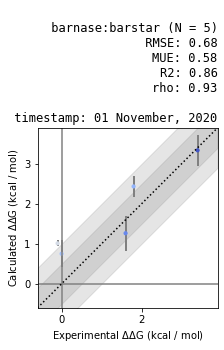

In [18]:
from datetime import date
today = date.today()
figsize=5

fig, ax = plt.subplots(figsize=(figsize, figsize))

# aesthetics
font_size = 14
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['font.size'] = font_size
plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.7)

plt.xlabel('Experimental $\Delta\Delta$G (kcal / mol)')
plt.ylabel(r'Calculated $\Delta\Delta$G (kcal / mol)')

ax_min = min(min(x), min(y)) - 0.5
ax_max = max(max(x), max(y)) + 0.5
scale = [ax_min, ax_max]

plt.xlim(scale)
plt.ylim(scale)

# plots x-axis and y-axis
origins=True
if origins:
    plt.plot([0, 0], scale, 'gray')
    plt.plot(scale, [0, 0], 'gray')

# plots x=y line
plt.plot(scale, scale, 'k:')
guidelines=True

if guidelines:
    small_dist = 0.5
    # plots grey region around x=y line
    plt.fill_between(scale, [ax_min - small_dist, ax_max - small_dist],
                     [ax_min + small_dist, ax_max + small_dist],
                     color='grey', alpha=0.2)
    plt.fill_between(scale, [ax_min - small_dist * 2, ax_max - small_dist * 2],
                     [ax_min + small_dist * 2, ax_max + small_dist * 2],
                     color='grey', alpha=0.2)
# actual plotting
cm = plt.get_cmap('coolwarm')

#if color is None:
color = np.abs(x-y)
# 2.372 kcal / mol = 4 RT
color = cm(color / 2.372)

plt.errorbar(x, y, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
plt.scatter(x, y, color=color, s=10, marker='o', zorder=2)

# stats and title
statistics_string = ''
for statistic in ['RMSE', 'MUE', 'R2', 'rho']:
    s = np.round(stats(x, y, statistic=statistic), 2)
    string = f"{statistic}: {s}\n"
    statistics_string += string
    
title = ''
target_name = 'barnase:barstar'
long_title = f'{title} \n {target_name} (N = {len(y)})\n {statistics_string} \n timestamp: {today.strftime("%d %B, %Y")}'
plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

plt.savefig('barnase_barstar_exp_vs_calc.png', dpi=300)

# Compute phase discrepancies

In [11]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [17]:
# mutations = ["T42A", "Y29A", "W38F", "W44F", "Y29F"]
mutations = ["T42A"]
d_discrepancy = {}
for mutation in mutations:
    reverse = mutation[-1] + mutation[1:-1] + mutation[0]
#     d_discrepancy[mutation] = [d_phases[mutation][0]*KT_KCALMOL, d_phases[reverse][0]*KT_KCALMOL, (d_phases[mutation][0] + d_phases[reverse][0])*KT_KCALMOL,
#                                d_phases[mutation][2]*KT_KCALMOL, d_phases[reverse][2]*KT_KCALMOL, (d_phases[mutation][2] + d_phases[reverse][2])*KT_KCALMOL]
    forward_apo_dg = d_phases[mutation][0]*KT_KCALMOL
    forward_apo_ddg = d_phases[mutation][1]*KT_KCALMOL
    reverse_apo_dg = d_phases[reverse][0]*KT_KCALMOL
    reverse_apo_ddg =  d_phases[reverse][1]*KT_KCALMOL
    apo_discrepancy = (d_phases[mutation][0] + d_phases[reverse][0])*KT_KCALMOL
    apo_uncertainty = np.sqrt((d_phases[mutation][1]*KT_KCALMOL)**2 + (d_phases[reverse][1]*KT_KCALMOL)**2)
    
    forward_complex_dg = d_phases[mutation][2]*KT_KCALMOL
    forward_complex_ddg = d_phases[mutation][3]*KT_KCALMOL
    reverse_complex_dg = d_phases[reverse][2]*KT_KCALMOL
    reverse_complex_ddg =  d_phases[reverse][3]*KT_KCALMOL
    complex_discrepancy = (d_phases[mutation][2] + d_phases[reverse][2])*KT_KCALMOL
    complex_uncertainty = np.sqrt((d_phases[mutation][3]*KT_KCALMOL)**2 + (d_phases[reverse][3]*KT_KCALMOL)**2)
    
    d_discrepancy[mutation] = [forward_apo_dg, forward_apo_ddg, reverse_apo_dg, reverse_apo_ddg, apo_discrepancy, apo_uncertainty, 
                              forward_complex_dg, forward_complex_ddg, reverse_complex_dg, reverse_complex_ddg, complex_discrepancy, complex_uncertainty]
    
    

In [18]:
d_discrepancy

{'T42A': [27.03648394372174,
  0.05161431036656872,
  -26.73342708051689,
  0.05238974865519397,
  0.3030568632048495,
  0.07354401946297796,
  29.712556095895806,
  0.11829541680060149,
  -28.240073955939362,
  0.11246888661466946,
  1.4724821399564438,
  0.16322700785216704]}

In [19]:
import pandas as pd
pd.DataFrame.from_dict(d_discrepancy, orient='index').to_csv("/data/chodera/zhangi/perses_benchmark/neq/8/discrepancies.csv")